# Imports

In [37]:
import pyomo.environ as pyo
from pyomo.dae import ContinuousSet, DerivativeVar
from pyomo.contrib.doe import DesignOfExperiments, MeasurementVariables, DesignVariables, ModelOptionLib
import copy
import numpy as np
from random import sample
from matplotlib import pyplot as plt

## Model function

In [4]:
def create_model(
    mod=None,
    model_option="stage2",
    control_time=[0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1],
    control_val=None,
    t_range=[0.0, 1],
    CA_init=1,
    C_init=0.1,
):
    """
    This is an example user model provided to DoE library.
    It is a dynamic problem solved by Pyomo.DAE.

    Arguments
    ---------
    mod: Pyomo model. If None, a Pyomo concrete model is created
    model_option: choose from the 3 options in model_option
        if ModelOptionLib.parmest, create a process model.
        if ModelOptionLib.stage1, create the global model.
        if ModelOptionLib.stage2, add model variables and constraints for block.
    control_time: a list of control timepoints
    control_val: control design variable values T at corresponding timepoints
    t_range: time range, h
    CA_init: time-independent design (control) variable, an initial value for CA
    C_init: An initial value for C

    Return
    ------
    m: a Pyomo.DAE model
    """

    theta = {"A1": 84.79, "A2": 371.72, "E1": 7.78, "E2": 15.05}

    model_option = ModelOptionLib(model_option)

    if model_option == ModelOptionLib.parmest:
        mod = pyo.ConcreteModel()
        return_m = True
    elif model_option == ModelOptionLib.stage1 or model_option == ModelOptionLib.stage2:
        if not mod:
            raise ValueError(
                "If model option is stage1 or stage2, a created model needs to be provided."
            )
        return_m = False
    else:
        raise ValueError(
            "model_option needs to be defined as parmest,stage1, or stage2."
        )

    if not control_val:
        control_val = [300] * 9

    controls = {}
    for i, t in enumerate(control_time):
        controls[t] = control_val[i]

    mod.t0 = pyo.Set(initialize=[0])
    mod.t_con = pyo.Set(initialize=control_time)
    mod.CA0 = pyo.Var(
        mod.t0, initialize=CA_init, bounds=(1.0, 5.0), within=pyo.NonNegativeReals
    )  # mol/L

    # check if control_time is in time range
    assert (
        control_time[0] >= t_range[0] and control_time[-1] <= t_range[1]
    ), "control time is outside time range."

    if model_option == ModelOptionLib.stage1:
        mod.T = pyo.Var(
            mod.t_con,
            initialize=controls,
            bounds=(300, 700),
            within=pyo.NonNegativeReals,
        )
        return

    else:
        para_list = ["A1", "A2", "E1", "E2"]

        ### Add variables
        mod.CA_init = CA_init
        mod.para_list = para_list

        # timepoints
        mod.t = ContinuousSet(bounds=t_range, initialize=control_time)

        # time-dependent design variable, initialized with the first control value
        def T_initial(m, t):
            if t in m.t_con:
                return controls[t]
            else:
                # count how many control points are before the current t;
                # locate the nearest neighbouring control point before this t
                neighbour_t = max(tc for tc in control_time if tc < t)
                return controls[neighbour_t]

        mod.T = pyo.Var(
            mod.t, initialize=T_initial, bounds=(300, 700), within=pyo.NonNegativeReals
        )

        mod.R = 8.31446261815324  # J / K / mole

        # Define parameters as Param
        mod.A1 = pyo.Var(initialize=theta["A1"])
        mod.A2 = pyo.Var(initialize=theta["A2"])
        mod.E1 = pyo.Var(initialize=theta["E1"])
        mod.E2 = pyo.Var(initialize=theta["E2"])

        # Concentration variables under perturbation
        mod.C_set = pyo.Set(initialize=["CA", "CB", "CC"])
        mod.C = pyo.Var(
            mod.C_set, mod.t, initialize=C_init, within=pyo.NonNegativeReals
        )

        # time derivative of C
        mod.dCdt = DerivativeVar(mod.C, wrt=mod.t)

        # kinetic parameters
        def kp1_init(m, t):
            return m.A1 * pyo.exp(-m.E1 * 1000 / (m.R * m.T[t]))

        def kp2_init(m, t):
            return m.A2 * pyo.exp(-m.E2 * 1000 / (m.R * m.T[t]))

        mod.kp1 = pyo.Var(mod.t, initialize=kp1_init)
        mod.kp2 = pyo.Var(mod.t, initialize=kp2_init)

        def T_control(m, t):
            """
            T at interval timepoint equal to the T of the control time point at the beginning of this interval
            Count how many control points are before the current t;
            locate the nearest neighbouring control point before this t
            """
            if t in m.t_con:
                return pyo.Constraint.Skip
            else:
                neighbour_t = max(tc for tc in control_time if tc < t)
                return m.T[t] == m.T[neighbour_t]

        def cal_kp1(m, t):
            """
            Create the perturbation parameter sets
            m: model
            t: time
            """
            # LHS: 1/h
            # RHS: 1/h*(kJ/mol *1000J/kJ / (J/mol/K) / K)
            return m.kp1[t] == m.A1 * pyo.exp(-m.E1 * 1000 / (m.R * m.T[t]))

        def cal_kp2(m, t):
            """
            Create the perturbation parameter sets
            m: model
            t: time
            """
            # LHS: 1/h
            # RHS: 1/h*(kJ/mol *1000J/kJ / (J/mol/K) / K)
            return m.kp2[t] == m.A2 * pyo.exp(-m.E2 * 1000 / (m.R * m.T[t]))

        def dCdt_control(m, y, t):
            """
            Calculate CA in Jacobian matrix analytically
            y: CA, CB, CC
            t: timepoints
            """
            if y == "CA":
                return m.dCdt[y, t] == -m.kp1[t] * m.C["CA", t]
            elif y == "CB":
                return m.dCdt[y, t] == m.kp1[t] * m.C["CA", t] - m.kp2[t] * m.C["CB", t]
            elif y == "CC":
                return pyo.Constraint.Skip

        def alge(m, t):
            """
            The algebraic equation for mole balance
            z: m.pert
            t: time
            """
            return m.C["CA", t] + m.C["CB", t] + m.C["CC", t] == m.CA0[0]

        # Control time
        mod.T_rule = pyo.Constraint(mod.t, rule=T_control)

        # calculating C, Jacobian, FIM
        mod.k1_pert_rule = pyo.Constraint(mod.t, rule=cal_kp1)
        mod.k2_pert_rule = pyo.Constraint(mod.t, rule=cal_kp2)
        mod.dCdt_rule = pyo.Constraint(mod.C_set, mod.t, rule=dCdt_control)

        mod.alge_rule = pyo.Constraint(mod.t, rule=alge)

        # B.C.
        mod.C["CB", 0.0].fix(0.0)
        mod.C["CC", 0.0].fix(0.0)

        if return_m:
            return mod


def disc_for_measure(m, nfe=32, block=True):
    """Pyomo.DAE discretization

    Arguments
    ---------
    m: Pyomo model
    nfe: number of finite elements b
    block: if True, the input model has blocks
    """
    discretizer = pyo.TransformationFactory("dae.collocation")
    if block:
        for s in range(len(m.block)):
            discretizer.apply_to(m.block[s], nfe=nfe, ncp=3, wrt=m.block[s].t)
    else:
        discretizer.apply_to(m, nfe=nfe, ncp=3, wrt=m.t)
    return m

## Helper Functions

### Create a doe object

In [7]:
def create_doe_object(Ca_val, T_vals, prior_FIM=None):
    t_control = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]
    parameter_dict = {"A1": 85, "A2": 370, "E1": 8, "E2": 15}
    
    measurements = MeasurementVariables()
    measurements.add_variables("C", indices={0: ["CA", "CB", "CC"], 1: t_control}, time_index_position=1)
    
    exp_design = DesignVariables()
    exp_design.add_variables(
        "CA0",
        time_index_position=0,
        values=[Ca_val, ],
        lower_bounds=1,
        indices={0: [0]},
        upper_bounds=5,
    )
    exp_design.add_variables(
        "T",
        indices={0: t_control},
        time_index_position=0,
        values=T_vals,
        lower_bounds=300,
        upper_bounds=700,
    )
    
    doe_object = DesignOfExperiments(
        parameter_dict,
        exp_design, 
        measurements, 
        create_model,
        prior_FIM=prior_FIM,
        discretize_model=disc_for_measure,
    )
    return doe_object

### Compute FIM using the compute_FIM function

In [8]:
def compute_specific_FIM(Ca_val, T_vals, prior_FIM=None, scale_param=True):
    doe_object = create_doe_object(Ca_val, T_vals, prior_FIM)

    result = doe_object.compute_FIM(
        mode="sequential_finite",
        scale_nominal_param_value=scale_param,
        formula="central",
    )
    result.result_analysis()
    
    return result

### Rescale FIM

In [9]:
def rescale_FIM(FIM, param_vals):
    param_scaling_mat = (1 / param_vals).transpose().dot(1 / param_vals)
    unscaled_FIM = np.multiply(FIM, param_scaling_mat)
    return unscaled_FIM

### Translate Jacobian to numpy array

In [25]:
def translate_jac(jac_dict):
    param_names = ['A1', 'A2', 'E1', 'E2']
    Q_all = np.array(list(jac_dict for p in param_names)).T
    return Q_all

### Get experimental conditions from solved model

In [11]:
def get_exp_conds(m):
    return [pyo.value(m.CA0[0]),
            pyo.value(m.T[0]),
            pyo.value(m.T[0.125]),
            pyo.value(m.T[0.25]),
            pyo.value(m.T[0.375]),
            pyo.value(m.T[0.5]),
            pyo.value(m.T[0.625]),
            pyo.value(m.T[0.75]),
            pyo.value(m.T[0.875]),
            pyo.value(m.T[1])]

### Run optimal experiment

In [33]:
def run_optimal_exp(Ca, Ta_vals, prior_FIM=None, scale_param=True):
    doe_object = create_doe_object(Ca, Ta_vals, prior_FIM)

    if prior_FIM is None:
        prior_FIM = np.eye(4)
    
    square_result, optimize_result = doe_object.stochastic_program(
        if_optimize=True,
        if_Cholesky=True,
        scale_nominal_param_value=scale_param,
        objective_option="det",
        L_initial=np.linalg.cholesky(prior_FIM),
    )
    
    return optimize_result

# Perform the analysis

In [38]:
D_sc = []
D_sc_2 = []
D_unsc = []
D_unsc_2 = []
exp_conds_sc = []
exp_conds_unsc = []
FIM_opt_sc = []
FIM_opt_sc_2 = []
FIM_opt_unsc = []
FIM_opt_unsc_2 = []
jac_opt_sc = []
jac_opt_sc_2 = []
jac_opt_unsc = []
jac_opt_unsc_2 = []
standard_Ca = 5
standard_T = [300, 300, 300, 300, 300, 300, 300, 300, 300, ]

FIM_new = None
FIM_new_unsc = None

FIM_running = np.zeros((4, 4))
FIM_running_unsc = np.zeros((4, 4))

for i in range(20):
    # Optimize experiment (scaled)
    sc_res = run_optimal_exp(standard_Ca, standard_T, FIM_new, True)
    # sc_res.result_analysis()
    sc_exp = get_exp_conds(sc_res.model)
    FIM_new = sc_res.FIM

    # Optimize experiment (unscaled)
    unsc_res = run_optimal_exp(standard_Ca, standard_T, FIM_new_unsc, False)
    # unsc_res.result_analysis()
    unsc_exp = get_exp_conds(unsc_res.model)
    FIM_new_unsc = unsc_res.FIM

    # Compute FIM in isolation (scaled)
    res_sc = compute_specific_FIM(sc_exp[0], sc_exp[1:], prior_FIM=None, scale_param=True)

    # Compute FIM in isolation (unscaled)
    res_unsc = compute_specific_FIM(unsc_exp[0], unsc_exp[1:], prior_FIM=None, scale_param=False)

    # Computing running isolation FIM
    FIM_running += res_sc.FIM
    FIM_running_unsc += res_unsc.FIM

    # Compute objectives (D-optimality)
    D_sc.append(np.log10(np.linalg.det(sc_res.FIM)))
    D_sc_2.append(np.log10(np.linalg.det(FIM_running)))
    D_unsc.append(np.log10(np.linalg.det(unsc_res.FIM)))
    D_unsc_2.append(np.log10(np.linalg.det(FIM_running_unsc)))

    # Append experimental results
    exp_conds_sc.append(sc_exp)
    exp_conds_unsc.append(unsc_exp)

    # Append FIM information
    FIM_opt_sc.append(FIM_new)
    FIM_opt_sc_2.append(copy.deepcopy(FIM_running))
    FIM_opt_unsc.append(FIM_new_unsc)
    FIM_opt_unsc_2.append(copy.deepcopy(FIM_running_unsc))

    # Append jacobian information
    jac_opt_sc.append(translate_jac(sc_res.jaco_information))
    jac_opt_sc_2.append(translate_jac(res_sc.jaco_information))
    jac_opt_unsc.append(translate_jac(unsc_res.jaco_information))
    jac_opt_unsc_2.append(translate_jac(res_unsc.jaco_information))

Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

## Plotting the results

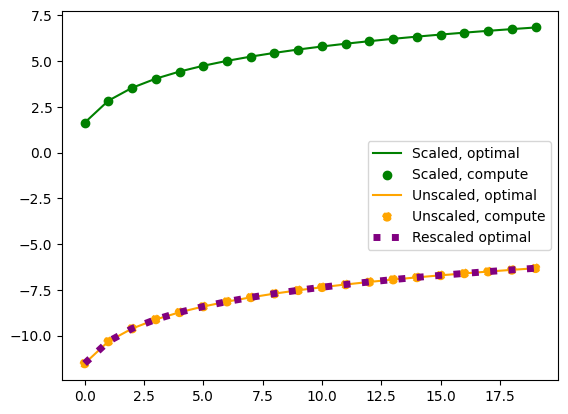

In [40]:
# Rescaling the scaled results
D_rescaled = []
param_vals = np.array([[85, 370, 8, 15], ])
for i in range(20):
    resc_FIM = rescale_FIM(FIM_opt_sc_2[i], param_vals)
    D_rescaled.append(np.log10(np.linalg.det(resc_FIM)))

plt.plot(range(20), D_sc, color='green', ls='-', label='Scaled, optimal')
plt.scatter(range(20), D_sc_2, color='green', label='Scaled, compute')
plt.plot(range(20), D_unsc, color='orange', ls='-', label='Unscaled, optimal')
plt.scatter(range(20), D_unsc_2, color='orange', ls='--', label='Unscaled, compute')
plt.plot(range(20), D_rescaled, color='purple', ls=':', lw=5, label='Rescaled optimal')

plt.legend()
plt.show()